In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
pd.set_option('display.expand_frame_repr', False)

from python_lib.pkl_saver import PklSaver
from sketch_formats.sketch_generator import *
from sketch_formats.sketch_instance import *
from plot.plot_common import *


import os
import sys
import argparse

out = "../../workload_manage/sensitivity2/output"
filename = "workload_varing_index_couputing_type.pkl"

print("[load output]")
out_saver = PklSaver(out, filename)
if out_saver.file_exist():
    output_dict = out_saver.load()
    print("[success]")
else:
    print("No output file, exit")
    exit(1)

[load output]
[success]


In [2]:

candidate_list = [output_dict["gd"]["bf"]["bf"], output_dict["o5"]]
name_list = ["gd_bf_bf", "o5"]

core_data_dict = {}
time_data_dict = {}
key_list_dict = {}
for candidate, name in zip(candidate_list, name_list):
    core_data = []
    time_data = []
    key_list_dict[name] = list(candidate.keys())
    for key, value in candidate.items():
        print(key, len(value))

        time_list = []
        base_list = []
        opt_list = []
        reduction_list = []

        for (time, data_sample, result) in value:
            time_list.append(time)
            
            if name == "o5":
                baseline_series = compute_heavy_hitter_baseline(data_sample)
                if result != None:
                    opt_series = result.objective_function()
                else:
                    opt_series = pd.Series([0, 0, 0, 0], index=['overall', 'salu', 'hashcall', 'sram'])

            else:
                baseline_series = compute_baseline(data_sample)
                opt_series = compute_objective_function(result)
            
            base_list.append(baseline_series.tolist())
            opt_list.append(opt_series.tolist())
            
            reduction_series = (baseline_series - opt_series)/(baseline_series+0.000001) * 100
            reduction_list.append(reduction_series.tolist())

        data = []
        data.append(base_list)
        data.append(opt_list)
        data.append(reduction_list)

        core_data.append(data)
        time_data.append(time_list)

    np_core_data = np.array(core_data) # (6, 3, 50, 4)
    np_core_data = np.swapaxes(np_core_data, 2, 3) # (6, 3, 4, 50)
    avg_data = np.mean(np_core_data, axis=3) # (6, 3, 4)
    avg_data = avg_data.reshape(avg_data.shape[0], avg_data.shape[1]*avg_data.shape[2]) # (6, 12)
    first_col = ['baseline']*4 + ['opt']*4 + ['reduction']*4
    second_col = ['overall', 'hashcall', 'salu', 'sram'] * 3
    df = pd.DataFrame(avg_data, columns = [first_col, second_col])
    core_data_dict[name] = df

    np_time_data = np.array(time_data) # (6, 50)
    avg_data = np.mean(np_time_data, axis=1) # (6)
    df = pd.DataFrame(avg_data, columns = ["time"])
    time_data_dict[name] = df

[1] 50
[2] 50
[1, 2] 50
[1] 50
[2] 50
[1, 2] 50


In [3]:
def get_plot_data(o1o4_base_df, o1o4_opt_df, o5_base_df, o5_opt_df):
    total_base = o1o4_base_df + o5_base_df
    total_opt = o1o4_opt_df + o5_opt_df
    
    total_result = (total_base - total_opt) / total_base * 100
    o1o4_result = (o1o4_base_df - o1o4_opt_df) / total_base * 100
    o5_result = (o5_base_df - o5_opt_df) / total_base * 100
    return total_result, o1o4_result, o5_result


gd_bf_bf
['[1]', '[2]', '[1, 2]']


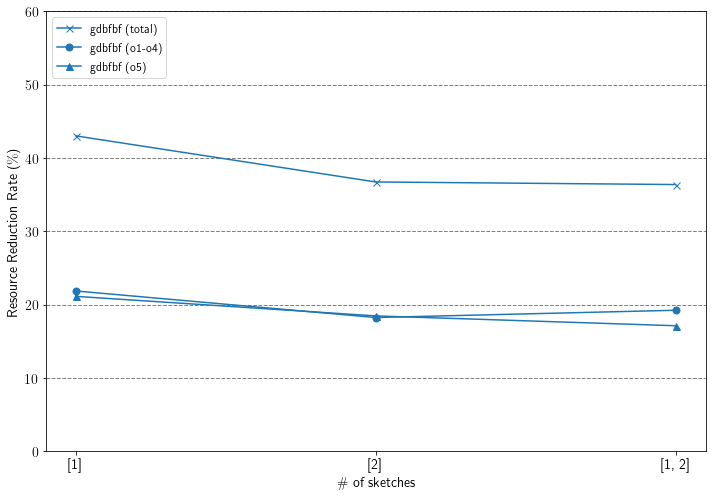

<Figure size 432x288 with 0 Axes>

In [4]:
fig_size = (10, 7)
fig, ax = plt.subplots(figsize=fig_size)

o5_base_df = core_data_dict["o5"]["baseline"]
o5_opt_df = core_data_dict["o5"]["opt"]
count = 0

# for name in ["bf", "gd_bf_bf", "gd_gd_bf", "gd_bf_gd", "gd_gd_gd"]:
for name in ["gd_bf_bf"]:
# for name in ["bf", "gd_bf_bf"]:

    o1o4_base_df = core_data_dict[name]["baseline"]
    o1o4_opt_df = core_data_dict[name]["opt"]
    color = "C%d" % count
    total_result, o1o4_result, o5_result = get_plot_data(o1o4_base_df, o1o4_opt_df, o5_base_df, o5_opt_df)
    print(name)
    print(key_list_dict[name])
    length = len(key_list_dict[name])
    ax.plot(key_list_dict[name], total_result["overall"][:length], label='%s (total)' % name.replace("_", ""), color=color, marker=markerst1, markersize=7, linestyle=linest)
    ax.plot(key_list_dict[name], o1o4_result["overall"][:length], label='%s (o1-o4)' % name.replace("_", ""), color=color, marker=markerst2, markersize=7, linestyle=linest)
    ax.plot(key_list_dict[name], o5_result["overall"][:length], label='%s (o5)' % name.replace("_", ""), color=color, marker=markerst3, markersize=7, linestyle=linest)
    count += 1

ax.set_ylabel('Resource Reduction Rate ($\%$)', fontsize=14)
ax.set_xlabel('$\#$ of sketches', fontsize=14)
plt.tick_params(labelsize=14)
plt.grid(color='gray', linestyle='--', linewidth=1, axis='y')
# plt.xticks(x_label)
# ax.set_title('%s' % item, fontsize=15)
ax.set_ylim([0, 60])
from matplotlib.ticker import MultipleLocator
# if item == "overall":
# plt.legend(loc="upper left", fontsize=12, ncol=3)
plt.legend(loc="upper left", fontsize=12)

fig.tight_layout()
# plt.savefig("%s.png" % item)
# plt.savefig("overall.pdf")
# plt.savefig("/Users/hnamkung/Desktop/mrb.png")
plt.show()
plt.clf()
